# Flow Basic

## Flow base モデルを用いるモチベーション
例.
1. 尤度推定を VAE や GANs よりも "うまく" やりたい    
    VAE は Reprezentation Trick などを使っているため、正確にデータから分布を移しているわけではない    
    GANs は画像生成などの分野で高い性能を出しているが、定式化が難しい
2. データの分布をより分析しやすい分布へ移す写像が欲しい

## Flow base モデルが何をやっているか

### ベースとなる式
関数 $f$ と データ $x$ について、次のような **分布の** 変換 $x -> z$ が行えるものとする。    

$$log p(x) = log p_z (f(x)) + log det |J(f(x))|$$    

ここで $J$ とは $f(x)$ についてのヤコビアンである。    

### 式の意味
この式を用いることで、データの分布 $p(x)$ をより解析しやすい分布 $p(z)$ へ移すことができる、としている。    
条件として、この $f(x)$ がその全単射な逆関数 $inv(f(x))$ を持つことで、一般にこのために Flow base モデルは Auto Encoder と比較して中間表現のパラメータ数は元のデータのパラメータ数と同じになる。   

### Flow base     

Flow baseと呼ばれるゆえんとしては、

$x <-> h_{1} <-> h_{2} <-> \cdots <-> z$     

というように小さな変換を行う全単射な関数を Flow な形に適用してデータの分布を写すアーキテクチャが一般的なモデル図であることが挙げられる。

### モデルの活用場面
このモデルの使い方としては、

1. データのエンコードとして、$x \rightarrow z$ を用い、
2. 任意の勾配を用いるなどして $z \rightarrow z'$ を獲得し、
3. 逆関数を通すことで $z' \rightarrow x'$ を得る

というものが挙げられる。実際 Glow や RealNVP では画像の変換の問題を解いている。

# 問題設定
$$p(x) \sim N(\mu_1., \sigma_1)$ -> $p(z) \sim N(\mu_2, \sigma_2)$$

の分布の変換を行う。つまり **->** の部分を Flow base model で補完する。

## 数式として解く
正規分布同士の変換であるとき、次のように分布の変換関数を定義することができる。

$$x = f^{-1}(z) = \mu + \sigma * z$$


$z$ について求めると、

$$z = \cfrac{x - \mu}{\sigma}$$

ヤコビアン行列の行列式(ヤコビアン)は次のようになる


\begin{eqnarray*}
det|J(f^{-1}(z))| &=& det |\cfrac{d f^{-1}}{d z}|\\ &=& det |\cfrac{d (\mu + \sigma * z)}{d z}| \\
 &=& det |\sigma|\\ &=& \sigma
\end{eqnarray*}

## Tensorflow を用いて解く
この変換をFlow baseモデルを用いて解いてみる。    
使うフレームワークは、 Tensorflow 2.0 を採用した。    

Tensorflow 2.0 は Tensorflow 1.x に比べ、Eager Execution が標準で有効になっている点で大きく異なる。    
これによって PyTorch といったフレームワークと同じように計算を実行することができるようになった。    

In [2]:
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
import tensorflow_probability as tfp

tfd = tfp.distributions
tfb = tfp.bijectors

print('tensorflow: ', tf.__version__)
print('tensorflow-probability: ', tfp.__version__)

tensorflow:  2.0.0-rc0
tensorflow-probability:  0.8.0-rc0


Target Distribution $N (5, 5)$

In [40]:
BATCH_SIZE = 512

target_dist = tfd.Normal(loc=5., scale=5.)
target_samples = lambda :target_dist.sample(BATCH_SIZE)

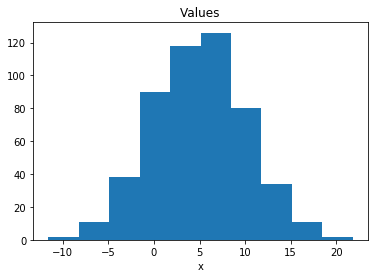

In [41]:
def draw_data(data):
    plt.hist(data)
    plt.title('Values')
    plt.xlabel('x')
    plt.show()

draw_data(target_samples())

In [208]:
class ScaleAndShift(tfb.Bijector):
    def __init__(
        self, mu=0.0, sigma=0.0, validate_args: bool = False, name="scale_and_shift"
    ):
        super(ScaleAndShift, self).__init__(
            validate_args=validate_args, forward_min_event_ndims=0, name=name
        )
        self.mu = tf.Variable(mu, name=self.name + "/mu")
        self.sigma = tf.Variable(sigma, name=self.name + "/sigma")

    def _forward(self, x):
        return x * self.sigma + self.mu

    def _inverse(self, y):
        return (y - self.mu) / self.sigma

    def _inverse_log_det_jacobian(self, y):
        # event_ndims > 0 であっても
        # Jacobian 計算時の、畳込み (reducing) については、Bijectorは勝手に計算してくれます。
        # 基底クラス Bijector は super. __init__ 時に引数として与えられる
        # forward_min_event_ndims の値を見て判断をします。
        # 例えば、
        # element_wise 単位で影響を与える場合、 forward_min_event_ndims = 0
        # ベクトル 単位で影響を与える場合、 forward_min_event_ndims = 1
        # Matrix 単位で影響を与える場合、 forward_min_event_ndims = 2
        # という風になります。
        return -self._forward_log_det_jacobian(self._inverse(y))

    def _forward_log_det_jacobian(self, x):
        return tf.math.log(self.sigma)

In [209]:
mu = 1.
sigma = 1.
scale_shift = ScaleAndShift(mu, sigma)
scale_shift.trainable_variables

(<tf.Variable 'scale_and_shift/mu:0' shape=() dtype=float32, numpy=1.0>,
 <tf.Variable 'scale_and_shift/sigma:0' shape=() dtype=float32, numpy=1.0>)

Base Distribution: $N(0, 1)$

In [210]:
base_dist = tfd.Normal(loc=0., scale=1.)

flow = tfd.TransformedDistribution(
    distribution=base_dist,
    bijector=tfb.Chain(list(reversed([scale_shift])))
)

flow.trainable_variables

(<tf.Variable 'scale_and_shift/mu:0' shape=() dtype=float32, numpy=1.0>,
 <tf.Variable 'scale_and_shift/sigma:0' shape=() dtype=float32, numpy=1.0>)

学習前のサンプリング結果

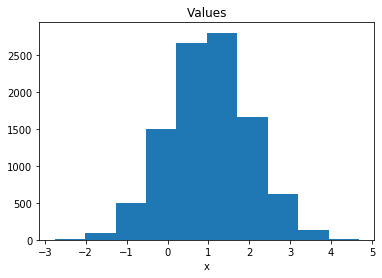

In [211]:
sample = flow.sample(10000)
draw_data(sample)

In [212]:
losses = []


def loss():
    loss = -tf.reduce_mean(flow.log_prob(target_samples()))
    losses.append(loss)
    return loss


optimizer = tf.optimizers.Adam(learning_rate=0.2)


checkpoint = tf.train.Checkpoint(
    model=flow, optimizer=optimizer, optimizer_step=optimizer.iterations
)
checkpoint.restore(tf.train.latest_checkpoint("checkpoints"))

for i in range(10000):
    optimizer.minimize(loss, var_list=flow.trainable_variables)
    if i % 100 == 0:
        checkpoint.save(os.path.join("checkpoints", "ckpt"))
print(flow.trainable_variables)

(<tf.Variable 'scale_and_shift/mu:0' shape=() dtype=float32, numpy=4.8726945>, <tf.Variable 'scale_and_shift/sigma:0' shape=() dtype=float32, numpy=5.1421113>)


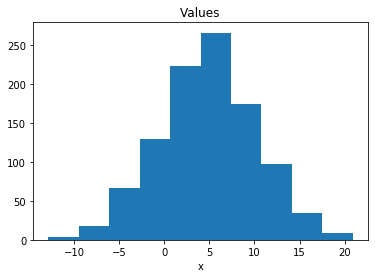

In [213]:
samples = flow.sample(1024)
draw_data(samples)

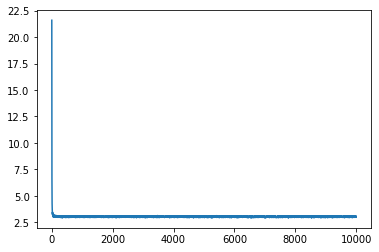

In [214]:
plt.plot(losses)

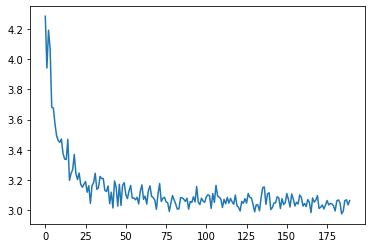

In [215]:
plt.plot(losses[10:200])